# Running simulations inside Docker

In this tutorial, we show how to run simulations inside Docker. More precisely, we show how to choose a `runner`. Docker helps us run simulations on a "small linux machine", which is automatically pulled from the cloud, simulations are run inside, and in the end it is destroyed automatically. This all happens in the background and requires no special assistance from the user. In order to use Docker, we need to have it installed on our machine - you can download it here: https://www.docker.com/products/docker-desktop.

For that example, we simulate a skyrmion in a sample with periodic boundary conditions.

In [1]:
import oommfc as mc
import discretisedfield as df
import micromagneticmodel as mm

We define mesh in cuboid through corner points `p1` and `p2`, and discretisation cell size `cell`. To define periodic boundary conditions, we pass an additional argument `bc`. Let us assume we want the periodic boundary conditions in $x$ and $y$ directions.

In [2]:
region = df.Region(p1=(-50e-9, -50e-9, 0), p2=(50e-9, 50e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9), bc='xy')

Now, we can define the system object:

In [3]:
system = mm.System(name='skyrmion')

system.energy = (mm.Exchange(A=1.6e-11)
               + mm.DMI(D=4e-3, crystalclass='Cnv') 
               + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
               + mm.Zeeman(H=(0, 0, 0.2e5)))

Ms = 1.1e6

def m_init(pos):
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 10e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_init, norm=Ms)

Now, we can define the runner object, so our simulations are run inside Docker.

In [4]:
runner = mc.oommf.DockerOOMMFRunner()

Finally we can minimise the energy and plot the magnetisation. When we create a `MinDriver` object, we pass `runner`.

**IMPORTANT:** On Windows, if OOMMF does not support some energy terms, choosing runner happens automatically in the background and requires no assistance from the user. However, you can still be explicit and tell ubermag how you want to run the simulation.

Running OOMMF (DockerOOMMFRunner) [2020/07/01 21:26]... (2.8 s)


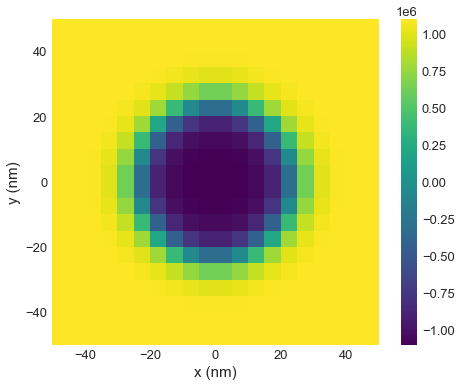

In [5]:
# minimize the energy
md = mc.MinDriver()
md.drive(system, runner=runner)

# md.drive(system)  # on Windows

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').z.mpl()

The first time we run the simulation, it is going to take some time for docker to pull an image from the cloud, but after that, the image will be known by docker, so there will be no delays for any further runs.